In [1]:
import sys
import yt.units as u
import numpy
import numpy as np
import matplotlib.pyplot as plt
import pyximport

from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import h5py
import os
import numpy
import h5py

os.environ['HDF5_DIR'] = '/home/kwoksun2/anaconda2/'

/home/kwoksun2/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


 using cli
 using CLI for selections


# Generate Initial Condition based on Temperature and Density

In [2]:
def Init_values(temperature, density, n_species = 9, cooling=True, size=10):
    """ Create a initial value dictionary,
        for a given temperature, density, number of species
    Args:
        temperature -- in Kelvin
        density     -- in amu / cm**3
        n_species   -- number of species (6/9)
        cooling

    Returns:
        init_values: initial value dictionary with
                     self-consistent energy/ electron density
        primordial : chemical_network classes

    """

    # initialize and setup the network
    dengo.primordial_rates.setup_primordial()
    primordial = ChemicalNetwork()
    primordial.threebody = 4
    primordial.include_binding_energy = 0
    
    if n_species == 9:
        for i in range(22):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass
    else:
        for i in range(6):
            try:
                primordial.add_reaction("k{0:02d}".format(i+1))
            except:
                pass

    # the temperature array required to interpolates the rates
    primordial.init_temperature((1e0, 1e5))

    tiny = 1.0e-20

    # init_array are is in fractional abundances
    init_values = dict()
    density = numpy.array([density])*numpy.ones((size))
    if n_species == 6:
        # 6-species model
        init_values["He_1"]    = density * (1.0 - 0.76)
        init_values["He_2"]    = np.array([tiny])
        init_values["He_3"]    = np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = np.array([tiny]) 
    else:
        # 9-species model
        init_values["He_1"]    = density * (1.0 - 0.76) 
        init_values["He_2"]    = density *np.array([tiny])
        init_values["He_3"]    = density *np.array([tiny])
        init_values["H_1"]     = density *  (0.76)
        init_values['H_2']     = density *np.array([tiny])

        init_values["H_m0"]    = density *np.array([tiny])
        init_values["H2_1"]    = density *np.array([tiny])
        init_values["H2_2"]    = density *np.array([tiny])

    # now everything in mass density
    init_values['de'] = primordial.calculate_free_electrons(init_values)
    # one signle value: again mass density
    init_values['density'] = primordial.calculate_total_density(init_values)

    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init_values[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    init_values['T'] = numpy.array([temperature])*numpy.ones((size))
    ge_array = numpy.ones((size))
    init_values['ge'] = ge_array
    
    # calculate gammaH2
    
    for i in range(size):
        
        temperature = init_values['T'][i]
        x = 6100.0/temperature
        expx = numpy.exp(x)
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*expx / (expx - 1 )**2.0 ) + 1

        rs = primordial.required_species
        H2_1_sp = list(rs)[0]
        gammaH2 = primordial.species_gamma(H2_1_sp,name=False, temp=True).subs({'T':temperature})

        new_num_den = {}
        for ele in num_den.keys():
            new_num_den[ele] = num_den[ele][i]
        
        gamma_factor = primordial.gamma_factor().subs(new_num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

        ge  = ((temperature *  kboltz) *gamma_factor
                             / (init_values['density'][i] * mh  ))

        
        T = init_values['density']*ge*mh / kboltz / gamma_factor
        init_values['ge'][i] = numpy.float64(ge)
    print(ge)
    if cooling:
        for cooling_action in cooling_registry:
            k = cooling_registry[cooling_action]
            if (k.species).issubset( primordial.required_species ):
                if k.name != "cie_cooling":                    
                    print("adding cooling: {}".format(k.name) )
                    primordial.add_cooling(cooling_action)
    return init_values, primordial

# Generate Initial Condition and Write the solver 

In [ ]:
density = 1e14
initial_temperature = 3000.0
final_time = (1.0 / (u.G * u.mass_hydrogen * u.cm**-3 * density)**0.5).in_cgs().v



init, primordial = Init_values(initial_temperature, 
                               density, n_species = 9, 
                               cooling=True,size=1)
primordial.stop_time = final_time


solver_name = "final_"

# solver tempelate are organized into different folders
# cv/sundials_CVDls is the latest one
# and it has to be used together with "initialize_cvode_solver.C"

primordial.write_solver(solver_name, output_dir = ".",
    solver_template = "cv/sundials_CVDls",
    ode_solver_source = "initialize_cvode_solver.C",
    init_values=init,
    input_is_number=False)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [52]:
3 % 2

1

In [24]:
# %load run_test_cvdls
#!/bin/bash

rm -f a.out
gcc final__solver.C final__solver_main.C initialize_cvode_solver.C -I. -I/home/kwoksun2/cvode-3.1.0/instdir/include/ -lm -lstdc++ -lhdf5 -lhdf5_hl /home/kwoksun2/cvode-3.1.0/instdir/lib/libsundials_cvode.a /home/kwoksun2/cvode-3.1.0/instdir/lib/libsundials_nvecserial.a -O3

rm -rf cvdls_solution
mkdir cvdls_solution

for i in {1..256}
do
    echo "$i th strip" 
    time ./a.out input_data/"$i.h5" cvdls_solution/"$i""_solution.h5"
    python -W ignore test_accuracy.py -t cvdls_solution/"$i""_solution.h5" -s accurate_solution/"$i"_accurate_solution.h5 
done


# Profiling the Code

- ## Build executables from the source files with `Makefile`
```bash
make clean
make OPTIONS="-DCVSPILS -DMAX_NCELLS=1024" # for the CVSPils (scaled, preconditioned, iterative linear solver)
make OPTIONS="-DMAX_NCELLS=1"              # for default CVDls (Direct linear solver)
```    


- ## Arguments of the Execuatble `run_dengo`
    a. the input hdf5 file (a dictionary with species abundance, and internal energy) **Default**: (`{{solver_name}}_initial_conditions.h5`)  
    b. the output hdf5 filename; **Default**: (`{{solver_name}}_solution.h5`)  
    c. the final time of the chemical evolution; **Default** (freefall time)   

- ## Run a do loop over the grid of initial conditions (`run_test_cvdls / cvspils`)

```sh
for i in {1..256}
do
    echo $i th strip
    time ./run_dengo input_data/$i.h5 cvdls_solution/$i_solution.h5
    python -W ignore test_accuracy.py -t cvdls_solution/"$i""_solution.h5" -s accurate_solution/"$i"_accurate_solution.h5 
done
```   

- ## Extract the timing/ accuracy information

In [7]:
def get_name_from_file( name = "real", filename = 'runtest.output' ):
    f = open(filename, 'r')
    result = list()
    for line in f:
        if name in line:
            result.append(line)
    f.close()
    return result

def change_time_to_s( min_s ):
    minutes, seconds =  min_s.strip('s').split('m')
    minute = float(minutes)
    second = float(seconds)
    
    total_time = minute*60.0 + second
    
    return total_time

def make_2dcolorplot( time_taken, title = "runtime", cbar_label = 'log ( dengo runtime / grackle runtime )', vmin = -5, vmax = 0 , cmap = 'viridis'):
    fig,ax = plt.subplots(dpi = 200)
    timemap = ax.pcolor(temp_2d, den_2d, numpy.log10( (time_taken )    ) , vmin=vmin, vmax=vmax , cmap=cmap)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set
    cbar = plt.colorbar(timemap)
    cbar.set_label( cbar_label )
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Density ($cm^{-3}$)')
    ax.set_title(title)

Tdim = 16
Ddim = 16

temp_list = numpy.logspace(2,3.7,Tdim)
den_list  = numpy.logspace(0,14,Ddim)

temp_2d, den_2d = numpy.meshgrid(temp_list,den_list)
den_temp_pair2d = numpy.dstack( (temp_2d,den_2d)  )

den_temp_pair2d = ( numpy.reshape(den_temp_pair2d, (Tdim*Ddim,2) )  )

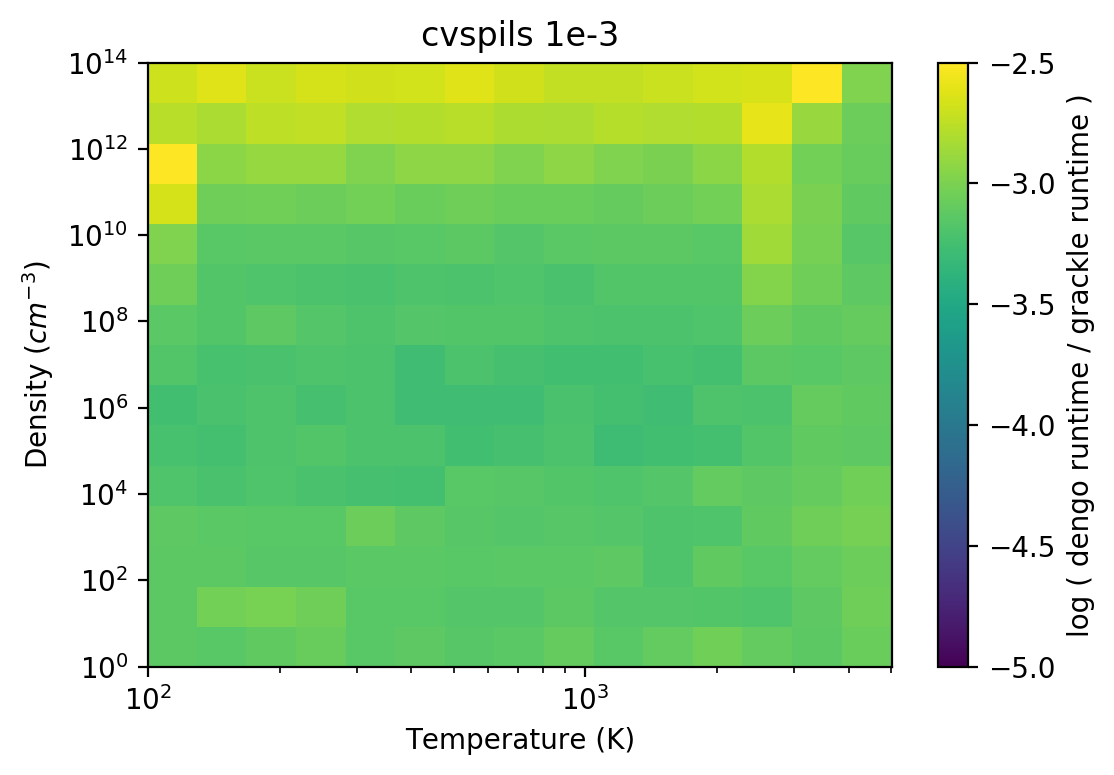

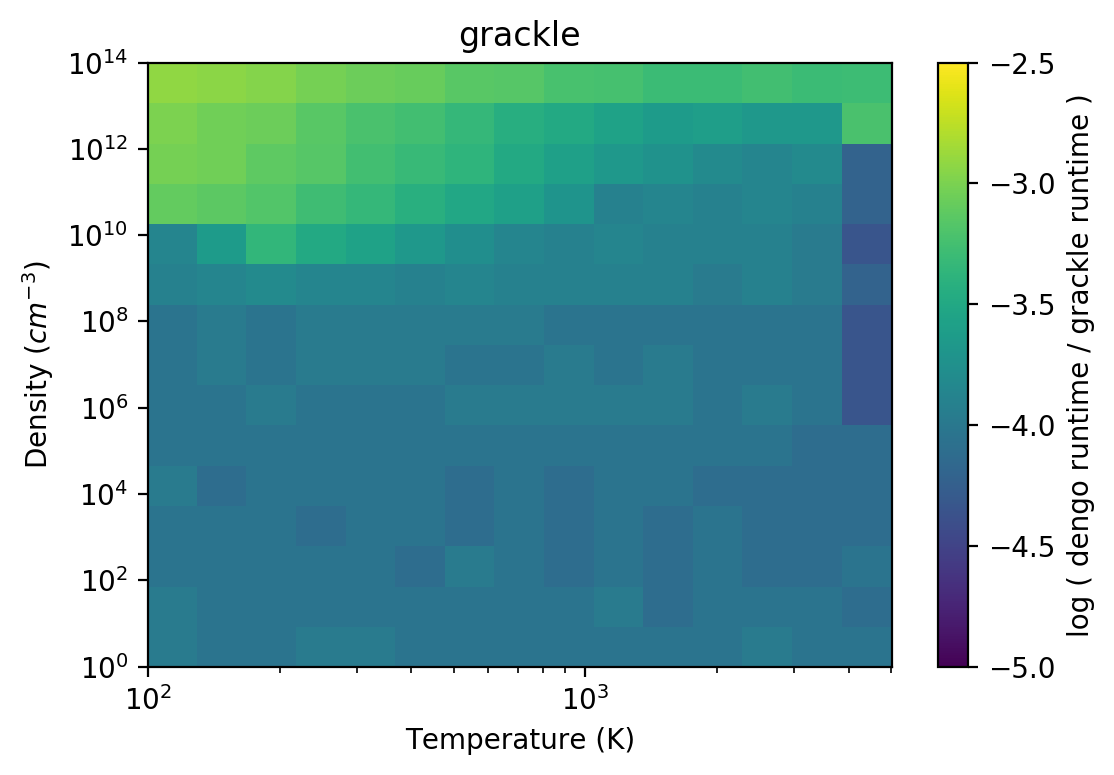

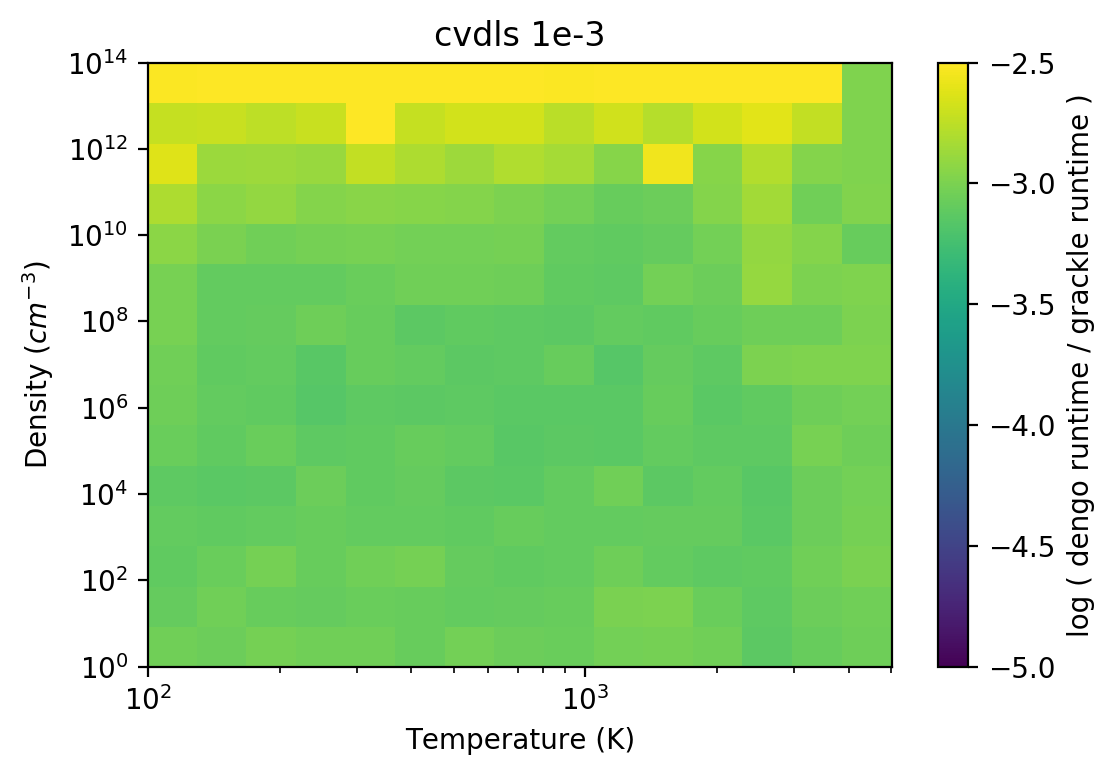

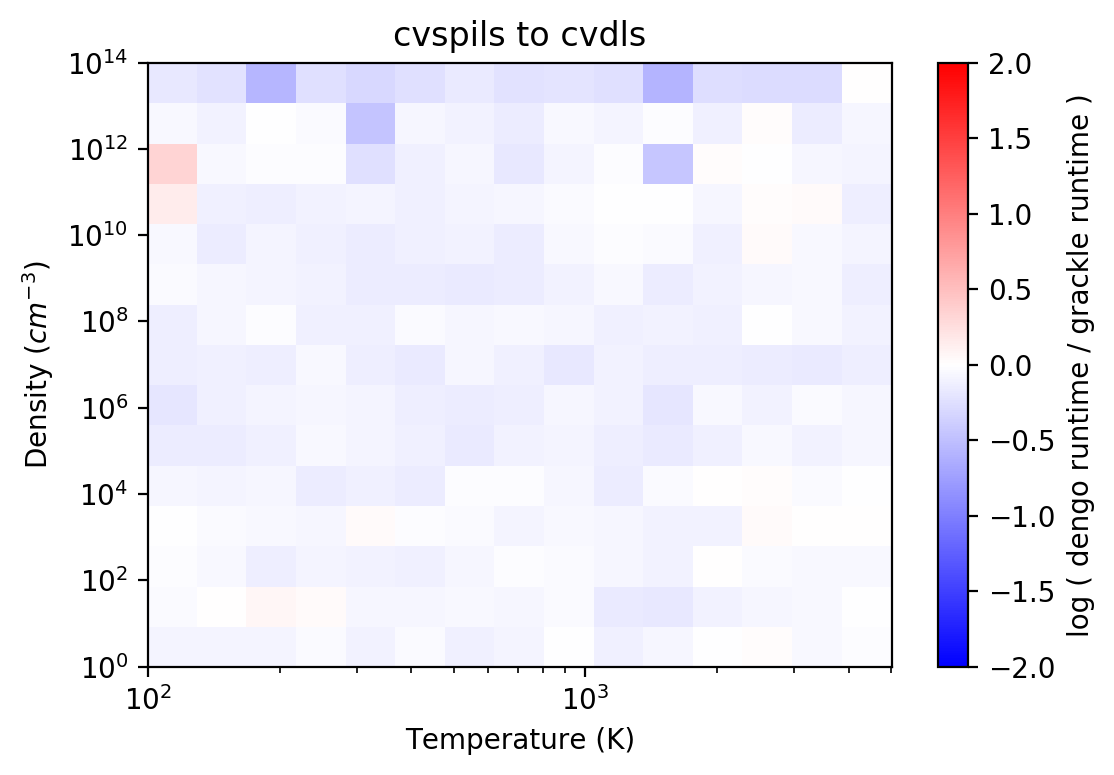

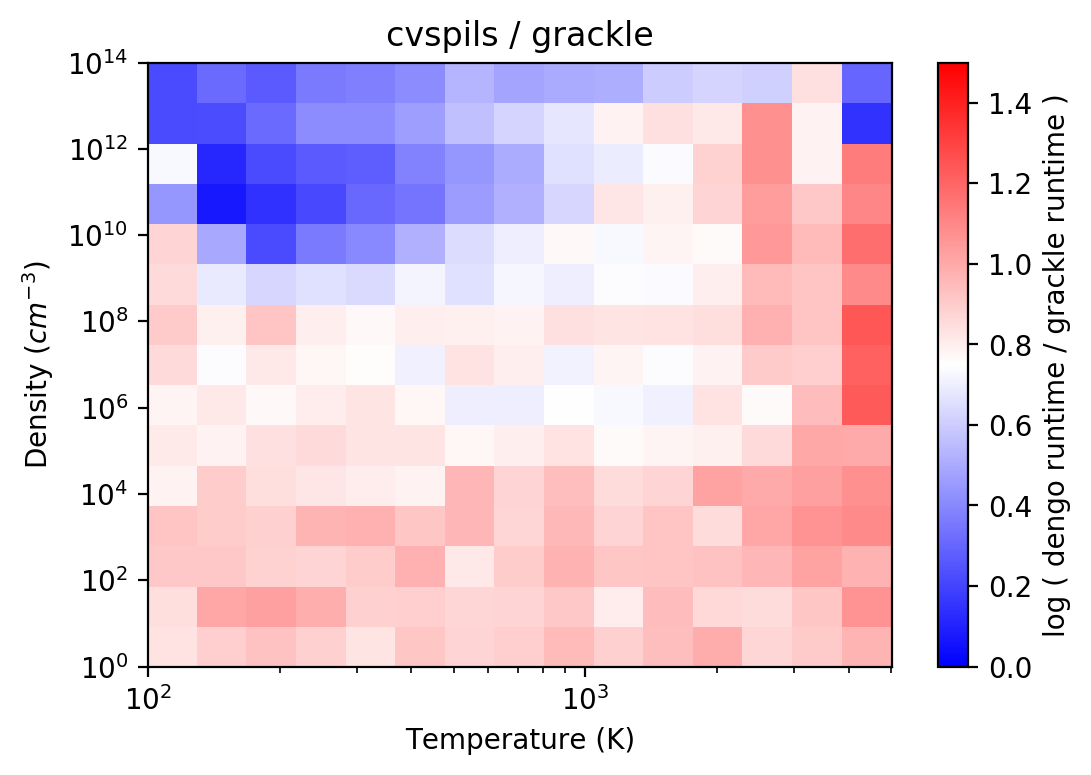

In [27]:

# reading data from the output file
time = get_name_from_file(filename = 'run_test_cvspils.out')
real_time = []
for t in time:
    _time_ = t.strip("\n").split('\t')[1]
    real_time.append( change_time_to_s(_time_) )
    

time_taken_dengo = numpy.array(real_time).reshape((16,16))

grackle_timeout = "/home/kwoksun2/grackle/src/example/grackle_runtime.out"
grackle_2d = numpy.loadtxt(grackle_timeout).reshape((16,16))


old_time = get_name_from_file(filename = "run_test_cvdls.out")
old_real_time = []
for t in old_time:
    _time_ = t.strip("\n").split('\t')[1]
    
    old_real_time.append( change_time_to_s(_time_) )

old_time_taken_dengo = numpy.array(old_real_time).reshape((16,16))



# Make plots
make_2dcolorplot( time_taken_dengo/1024.0 ,  title = "cvspils 1e-3", vmin=-5, vmax=-2.5 )

make_2dcolorplot( grackle_2d/1024.0 ,  title = "grackle", vmin=-5, vmax=-2.5 )

make_2dcolorplot( old_time_taken_dengo/1024.0 ,  title = "cvdls 1e-3", vmin=-5, vmax=-2.5 )

make_2dcolorplot( time_taken_dengo / old_time_taken_dengo ,  title = "cvspils to cvdls", vmin=-2, vmax=2, cmap = plt.get_cmap('bwr') )

make_2dcolorplot( time_taken_dengo / grackle_2d ,  title = "cvspils / grackle", vmin=0, vmax=1.5 ,cmap = plt.get_cmap('bwr'))

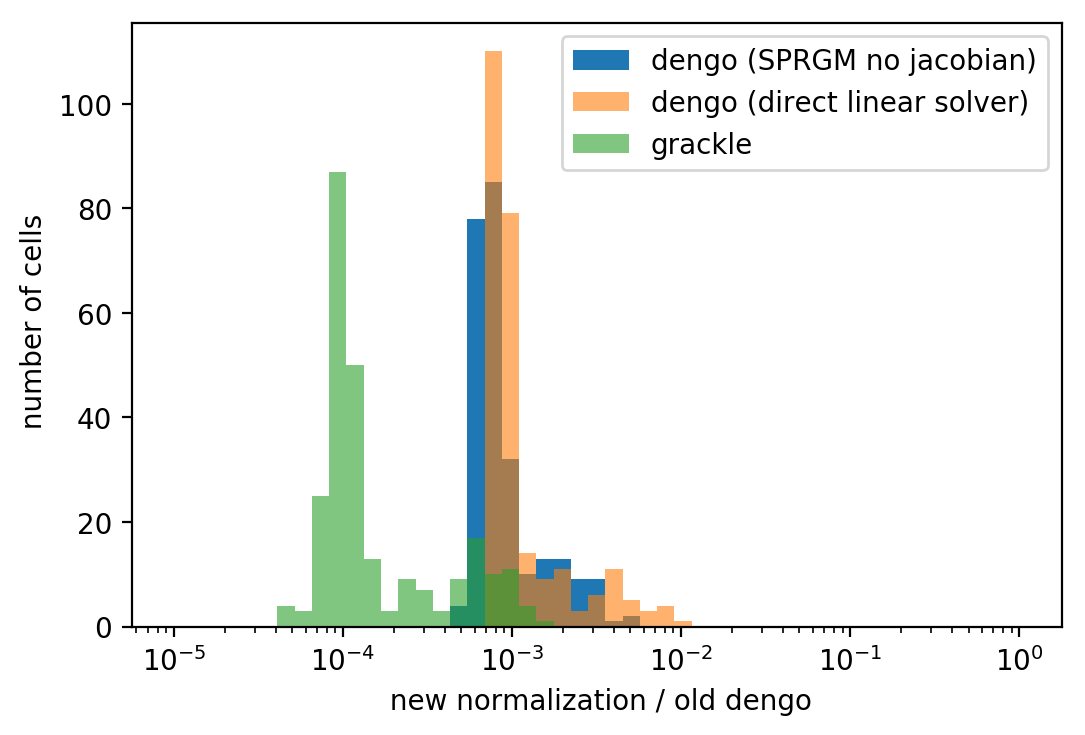

In [26]:
plt.figure(dpi=200)
plt.hist( (time_taken_dengo / 1024 ).flatten()  , bins=np.logspace( -5, 0, 50), label='dengo (SPRGM no jacobian)' )

plt.hist( (old_time_taken_dengo / 1024 ).flatten()  , bins=np.logspace( -5, 0, 50), alpha=0.6, label='dengo (direct linear solver)' )


plt.gca().set_xscale('log')
plt.xlabel(' new normalization / old dengo')
plt.ylabel(' number of cells')


plt.hist( ( grackle_2d / 1024  ).flatten()  , bins=np.logspace(-5, 0, 50), alpha=0.6, label='grackle' )
plt.legend()
plt.show()

# Alternatively, this can be imported as a python module

In [21]:
import pyximport
pyximport.install(setup_args={"include_dirs":np.get_include()},
                      reload_support=True, inplace=True)

sunny_solver_run = pyximport.load_module("final__solver_run",
                                "final__solver_run.pyx",
                                build_inplace = True, pyxbuild_dir = "_dengo_temp")

In [22]:
# this takes two input, the dictionary of initial condition and the evolve time
rv, rv_int = sunny_solver_run.run_final_(init, 1e10)

initial  temperature: 3.000E+03
Successful iteration[    0]: (1.000e+06) 1.000e+06 / 1.000e+10
End in 73 iterations: 1.00000e+10 / 1.00000e+10 (0.00000e+00)


In [23]:
rv_int

{'H2_1': array([[6.07002114e+13, 7.22092320e+13, 7.41095358e+13, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'H2_2': array([[9.97180607e-14, 8.19165762e-14, 7.40610338e-14, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'H_1': array([[1.52997886e+13, 3.79076796e+12, 1.89046418e+12, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'H_2': array([[1.49999995e-06, 1.49999996e-06, 1.49999996e-06, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'H_m0': array([[1.63420477e-12, 1.47359099e-12, 1.39524826e-12, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 'He_1': array([[2.4e+13, 2.4e+13, 2.4e+13, ..., 0.0e+00, 0.0e+00, 0.0e+00]]),
 'He_2': array([[1.e-06, 1.e-06, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00]]),
 'He_3': array([[1.e-06, 1.e-06, 1.e-06, ..., 0.e+00, 0.e+00, 0.e+00]]),
 'T': array([[2089.95940268, 1876.61117766, 1777.49558557, ...,    0.        ,
            0.        ,    0.        ]]),
 'de':

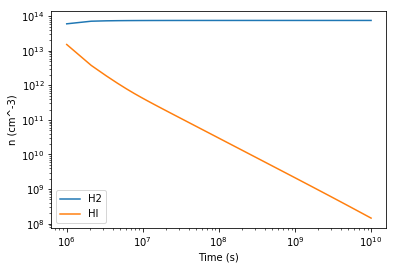

In [24]:
def get_success_data( init, element  ):
    flag = init['successful']
    t = init['t'][flag]
    return t, init[element][0][flag]

t, H2_1 = get_success_data( rv_int, 'H2_1'  )
t, H_1 = get_success_data( rv_int, 'H_1'  )

plt.loglog(t, H2_1, label = 'H2')
plt.loglog(t, H_1, label = 'HI')
plt.xlabel('Time (s)')
plt.ylabel('n (cm^-3)')
plt.legend()
plt.show()